Label map used: {0.0: 'negative', 1.0: 'neutral', 2.0: 'positive'}
Label encoding: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


Map:   0%|          | 0/3997 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1000/1000 [00:00<00:00, 37791.63 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_9804\865289513.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.487700,0.436167,0.832000,0.821561
2,0.389600,0.588488,0.811000,0.775379
3,0.256400,0.545447,0.819000,0.804893
4,0.159100,0.790552,0.819000,0.813042
5,0.048300,0.892957,0.818000,0.808080


Evaluation results: {'eval_loss': 0.8929573893547058, 'eval_accuracy': 0.818, 'eval_f1': 0.8080795088174837, 'eval_runtime': 2.2044, 'eval_samples_per_second': 453.631, 'eval_steps_per_second': 28.579, 'epoch': 5.0}
Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.91      0.89       766
     neutral       0.18      0.06      0.09        34
    positive       0.62      0.60      0.61       200

    accuracy                           0.82      1000
   macro avg       0.56      0.52      0.53      1000
weighted avg       0.80      0.82      0.81      1000



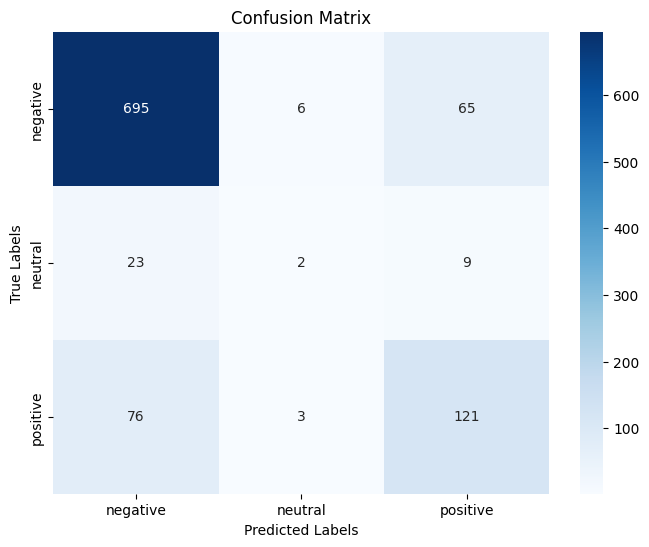

In [5]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Load dataset
data = pd.read_csv('RomanicBanglaSentiment.csv')
data.dropna(subset=['text', 'sentiment'], inplace=True)

# Map numeric labels to FinBERT labels (adjust as needed)
label_map = {
    0.0: 'negative',
    1.0: 'neutral',
    2.0: 'positive',
}
data['sentiment'] = data['sentiment'].map(label_map)

# Drop rows with unknown labels (e.g., 3.0 or others not in label_map)
data = data.dropna(subset=['sentiment'])

# Check if any supported labels exist
if data.empty:
    raise ValueError("No supported FinBERT labels found after mapping.")

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment'])

print("Label map used:", label_map)
print("Label encoding:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(data[['text', 'label']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load FinBERT
model_name = 'yiyanghkust/finbert-tone'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Tokenize
def tokenize(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training args
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Predict
pred_output = trainer.predict(dataset['test'])
preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

# Classification report
used_labels = sorted(unique_labels(true_labels, preds))
used_class_names = [label_encoder.classes_[i] for i in used_labels]

report = classification_report(
    true_labels,
    preds,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, preds, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [6]:
trainer.save_model('FinBERT')